In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Load the basic libraries
import matplotlib.pyplot as plt
import cv2
import os
import itertools
import tensorflow as tf
import skimage
import keras
import pydot
import seaborn as sns
import plotly.express as px

# Load data preprocessing's libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load libraries to build CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,GlobalMaxPool2D,Activation,GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

# Load VGGFace architecture
from keras import backend as K
from tensorflow.keras.applications import VGG16
from keras.models import load_model
from tensorflow.keras.models import Model

from tensorflow.keras.applications import EfficientNetB0

#load callbacks' libraries
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#load visualizing libraries
from matplotlib.image import imread
from tensorflow.keras.utils import plot_model
from skimage.transform import rescale, resize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'matplotlib'

# Data Exploration

In [2]:
train_path = "/kaggle/input/fer2013pluscleanedaugmballanced1/train"
test_path = "/kaggle/input/fer2013pluscleanedaugmballanced1/test"

In [3]:
# Showing different categories in the dataset
categories_train = os.listdir(train_path)
categories_test = os.listdir(test_path)
print(categories_train)
print(categories_test)

['Surprise', 'Fear', 'Neutral', 'Sad', 'Disgust', 'Happy', 'Anger']
['Surprise', 'Fear', 'Neutral', 'Sad', 'Disgust', 'Happy', 'Anger']


In [4]:
# Function to load images from a folder
def load_images(folder):
    images = []
    categories = []

    for emotion_folder in os.listdir(folder):
        category = emotion_folder
        for filename in os.listdir(os.path.join(folder, emotion_folder)):
            img = cv2.imread(os.path.join(folder, emotion_folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                categories.append(category)
    return images, categories

# Load images and labels from train and test folders
training_images, training_labels = load_images(train_path)
test_images, test_labels = load_images(test_path)


#list to numpy array
training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)


# Print the total number of images
print("Total number of training images:", len(training_images))
print("Total number of test images:", len(test_images))

Total number of training images: 23251
Total number of test images: 5772


## Show some Images in both Training and Test Set

### Training Set

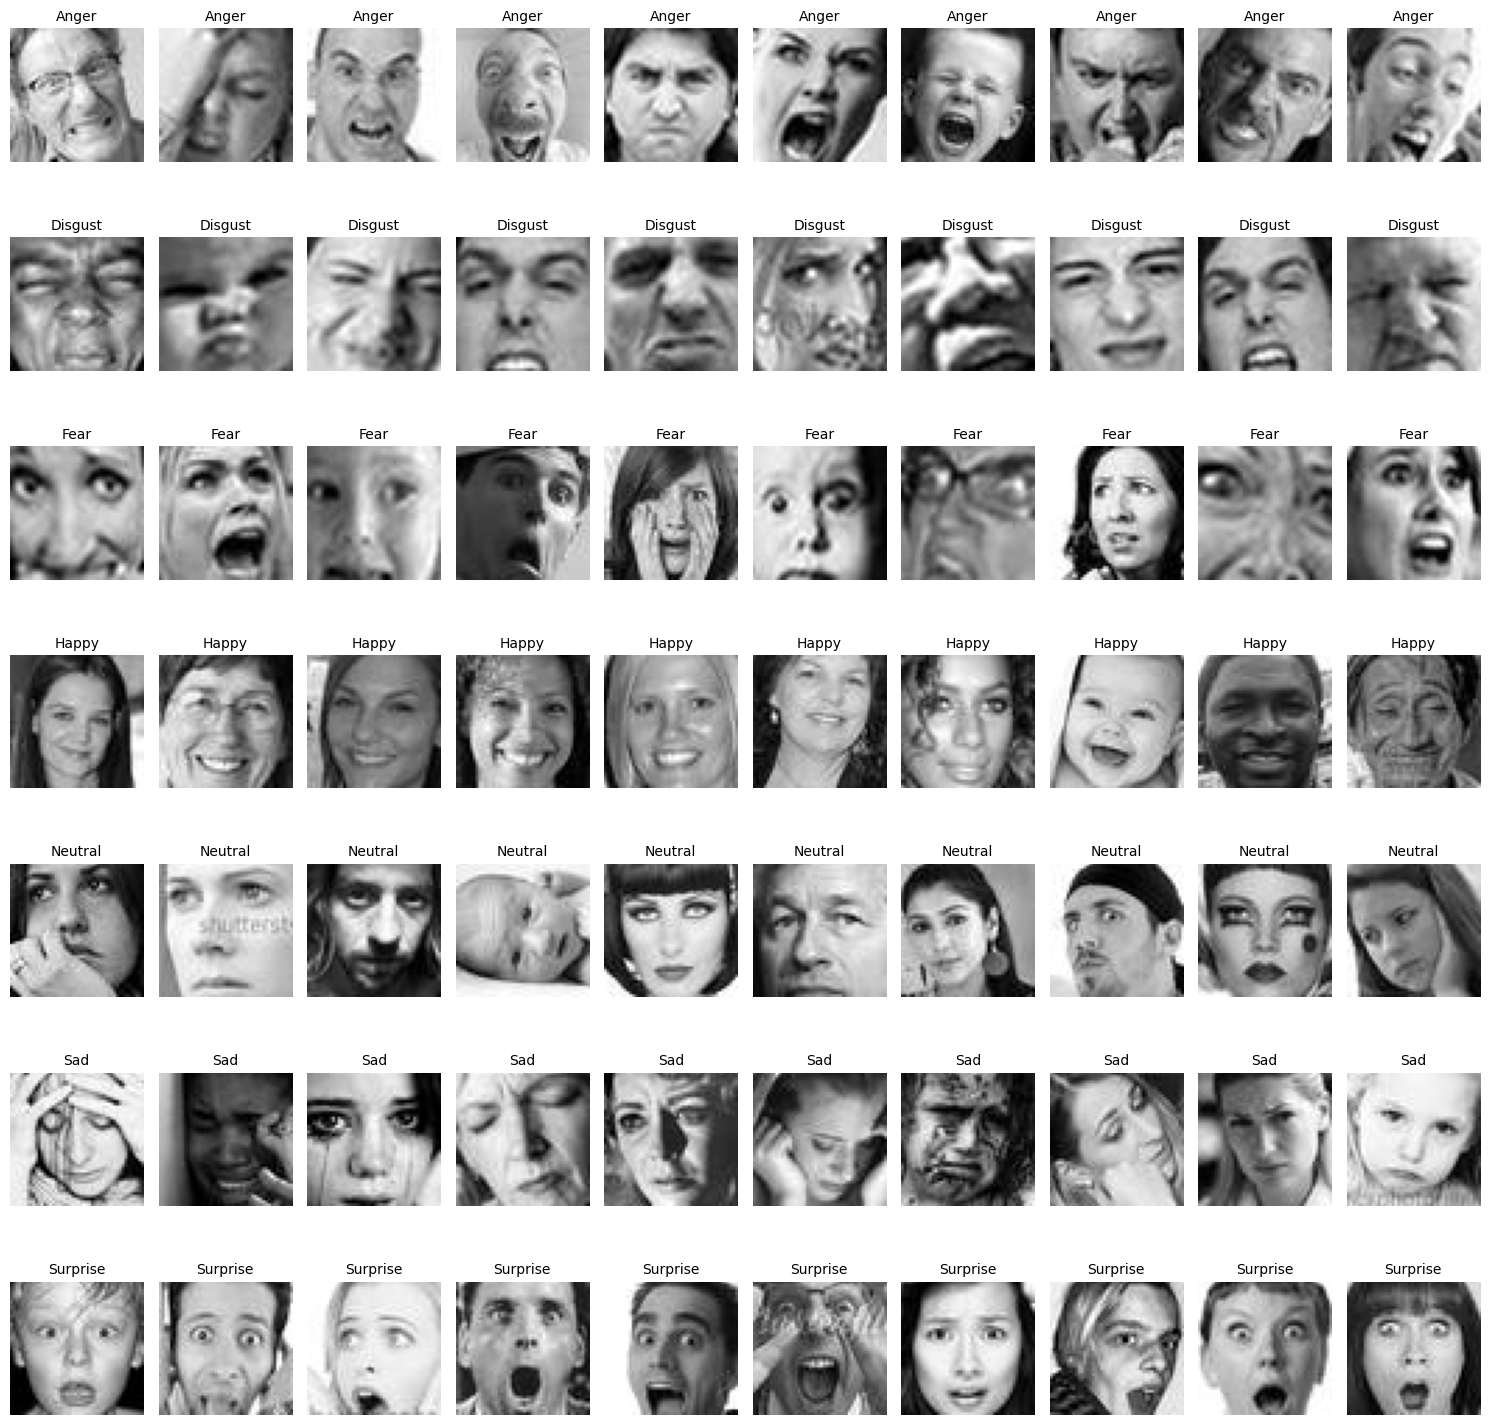

In [5]:
# Function to select sample images from each class
def select_sample(images, labels, sample_num=5):
    sample_images = []
    label_names = np.unique(labels)
    for label_name in label_names:
        label_indices = np.where(labels == label_name)[0][:sample_num]
        sample_images.extend(images[label_indices])
    return sample_images, label_names

sample_num = 10

# Select sample images and class names
sample_images, label_names = select_sample(training_images, training_labels, sample_num)

# Reshape training_images to have an additional dimension for grayscale channel
training_images = np.reshape(training_images, (len(training_images), 48, 48))

# Plot sample images in a grid
num_labels = len(label_names)
fig, axes = plt.subplots(num_labels, sample_num, figsize=(15, 15))
for i, class_name in enumerate(label_names):
    class_indices = np.where(training_labels == class_name)[0][:sample_num]
    for j, idx in enumerate(class_indices):
        axes[i, j].imshow(training_images[idx], cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name, fontsize=10)

plt.tight_layout()
plt.show()

### Test Set

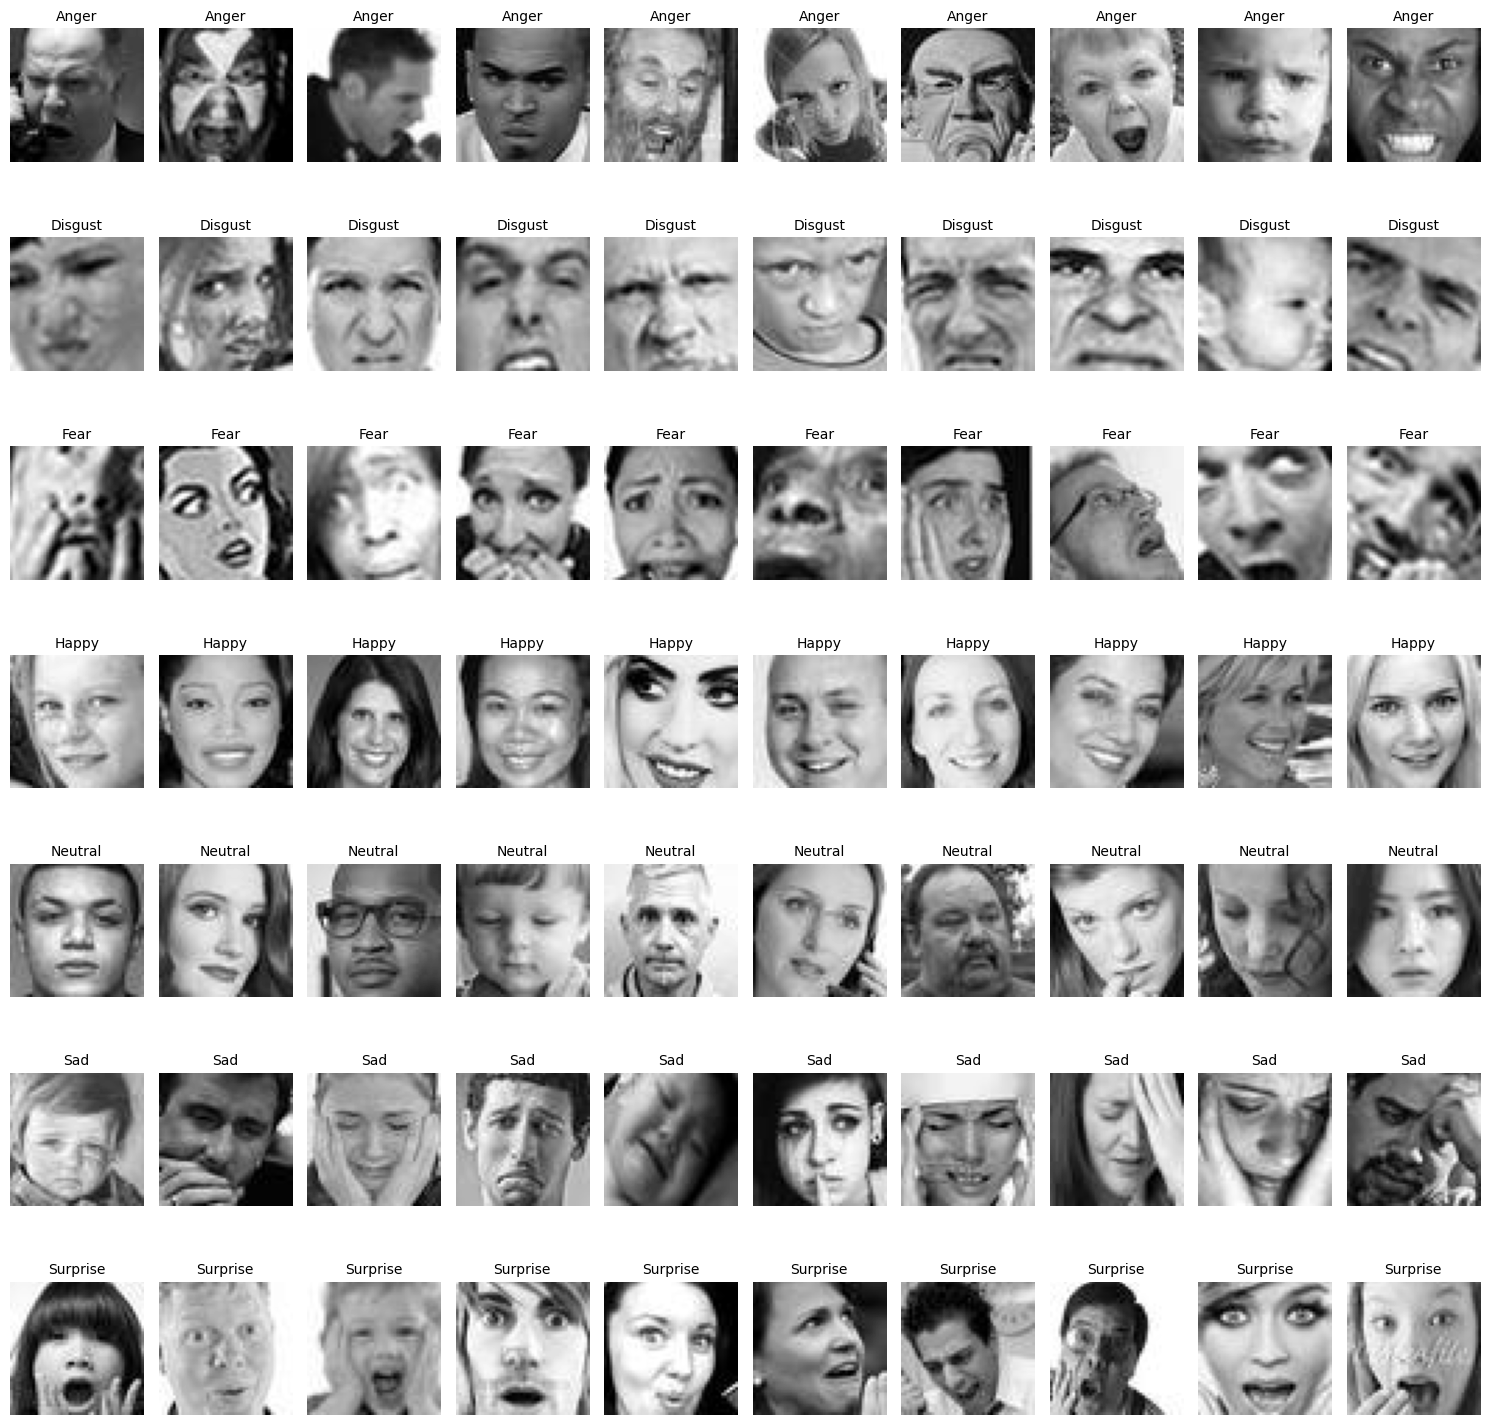

In [6]:
sample_num = 10

# Select sample images and class names
sample_images, label_names = select_sample(test_images, test_labels, sample_num)

# Reshape training_images to have an additional dimension for grayscale channel
test_images = np.reshape(test_images, (len(test_images), 48, 48))

# Plot sample images in a grid
num_labels = len(label_names)
fig, axes = plt.subplots(num_labels, sample_num, figsize = (15, 15))
for i, class_name in enumerate(label_names):
    class_indices = np.where(test_labels == class_name)[0][:sample_num]
    for j, idx in enumerate(class_indices):
        axes[i, j].imshow(test_images[idx], cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name, fontsize = 10)

plt.tight_layout()
plt.show()

## Data Visualization

In [7]:

# Calculate sum of images for each class in training set
training_count = {class_name: np.sum(training_labels == class_name) for class_name in np.unique(training_labels)}

# Create a bar chart using Plotly Express
ploting = px.bar(x = list(training_count.keys()), y = list(training_count.values()), color = list(training_count.keys()))

# Customize the layout of the chart
ploting.update_layout(
    title = {
        'text': "Total images for each class in training set",
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title = "Emotion",
    yaxis_title = "Count"
)
ploting.update_traces(texttemplate = '%{y}', textposition='inside')  # Display count labels on bar

# Display plot
ploting.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [8]:
# Calculate sum of images for each class in training set
test_count = {class_name: np.sum(test_labels == class_name) for class_name in np.unique(test_labels)}

# Create a bar chart using Plotly Express
ploting = px.bar(x = list(test_count.keys()), y = list(test_count.values()), color = list(test_count.keys()))

# Customize the layout of the chart
ploting.update_layout(
    title = {
        'text': "Total images for each class in test set",
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title = "Emotion",
    yaxis_title = "Count"
)
ploting.update_traces(texttemplate = '%{y}', textposition='inside')  # Display count labels on bar

# Display plot
ploting.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Model Architecture

## Customized VGG16 Model

In [9]:
# Set the batch size for training
new_batch_size = 128

# Define the dropout rate for regularization
dropout_rate = 0.5

# Specify the number of frozen layers in the model
frozen_layer = 170

# Set the learning rate for the Adam optimizer
adam_lr = 0.001

# Set the learning rate for the SGD optimizer
sgd_lr = 0.01

# Specify the target size for resizing input images
img_resize = 64

In [10]:
# Source : https://github.com/rcmalli/keras-vggface
# Source : https://www.codemag.com/Article/2205081/Implementing-Face-Recognition-Using-Deep-Learning-and-Support-Vector-Machines
# The original VGGFace uses the VGG16 model, which is a convolutional neural network with 16 layers

# Create the VGG16 model with specified input shape and average pooling
vgg_notop = VGG16(input_shape = (img_resize, img_resize, 3), include_top = False, pooling = 'avg')

# Get the output of the last layer of the VGG16 model
last_layer = vgg_notop.output

# Flatten the output
x = Flatten(name = 'flatten')(last_layer)

# Apply Dropout regularization
x = Dropout(dropout_rate)(x)

# Add a fully connected layer with 4096 units and ReLU activation
x = Dense(4096, activation = 'relu', name = 'fc6')(x)

# Apply Dropout regularization
x = Dropout(dropout_rate)(x)

# Add another fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation = 'relu', name = 'fc7')(x)

# Apply Dropout regularization
x = Dropout(dropout_rate)(x)

# Define the indices of layers to freeze during training
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]

# Freeze the specified layers by setting their trainable attribute to False
for i in range(frozen_layer):
    if i < len(vgg_notop.layers) and i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

# Add a dense layer with 7 units and softmax activation as the classifier layer
x = Dense(7, activation = 'softmax', name = 'classifier')(x)

# Create the vgg16 model with the modified layers
vgg16_model = Model(vgg_notop.input, x)


optim = tf.keras.optimizers.Adam(learning_rate=adam_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

sgd = tf.keras.optimizers.SGD(learning_rate=sgd_lr, momentum=0.9, nesterov=True)

# Compile the model with the specified optimizer, loss function, and metrics
vgg16_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

#model summary
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6 (Dense)                     │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,018,439 (80.18 MB)

 Trainable params: 9,290,567 (35.44 MB)

 Non-trainable params: 11,727,872 (44.74 MB)

# Create Data Augmentation

In [11]:
# Source : https://www.geeksforgeeks.org/python-data-augmentation/
# Source : https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
train_datagen = ImageDataGenerator(
    rescale = 1 / 255.,        # Rescale pixel values to be between 0 and 1
    rotation_range = 10,       # Rotates image with the number of degrees that we assigned
    zoom_range = 0.2,          # Zoom to our object randomly
    horizontal_flip = True,    # Randomly flip images horizontally
    height_shift_range = 0.1,  # Shift the height of images by up to 10% randomly
    width_shift_range = 0.1,   # Shift the width of images by up to 10% randomly
    fill_mode = 'nearest',     # Replaces the empty area with the nearest pixel values
    validation_split=0.2    # set the validation split
)

test_datagen = ImageDataGenerator(
    rescale = 1 / 255.
)

# Apply Augmentation to the images

In [12]:
# Train generator
print('Generate Training Set - ',end = ' ')
train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    class_mode = "categorical",
    target_size = (img_resize,img_resize),
    color_mode = 'rgb',
    batch_size = new_batch_size,
    shuffle = True,
    subset = 'training'

)

print('Generate Validation Set - ',end = ' ')
validation_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (img_resize,img_resize),
    batch_size = new_batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    subset = 'validation' # set as validation data
   )

# Test generator
print('Generate Shuffled Test Set - ', end = ' ')
test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    class_mode = 'categorical',
    target_size = (img_resize,img_resize),
    color_mode = 'rgb',
    batch_size = new_batch_size,
    shuffle = True
)

Generate Training Set -  Found 18603 images belonging to 7 classes.
Generate Validation Set -  Found 4648 images belonging to 7 classes.
Generate Shuffled Test Set -  Found 5772 images belonging to 7 classes.


# Create Callbacks

In [13]:
steps_per_epoch = train_generator.n // train_generator.batch_size
print(steps_per_epoch)

validate_steps = validation_generator.n // validation_generator.batch_size
print(validate_steps)

145
36


In [14]:
# Source : https://keras.io/api/callbacks/model_checkpoint/
checkpoint_filepath = "new_finalVGG16_weight.weights.h5"

# Save model weights
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    verbose = 1
)

# Source : https://keras.io/api/callbacks/reduce_lr_on_plateau/
# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning if the model loss does not decrease
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 10,
    min_lr = 0.00001, 
    verbose = 1
)

# Source : https://keras.io/api/callbacks/early_stopping/
# Create Early Stopping Callback to monitor the accuracy
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.005,
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

callbacks = [checkpoint_callback, reduce_lr, early_stopping]

# Model Training

In [15]:
# vgg16_model_history = vgg16_model.fit(
#     train_generator,
#     validation_data = validation_generator,
#     epochs = 300,
#     callbacks = callbacks,
#     steps_per_epoch = steps_per_epoch,
#     validation_steps = validate_steps,
#     verbose = 1
# )

# Model Evaluation

In [ ]:
# Get the training and validation accuracy from the history
train_acc = vgg16_model_history.history['accuracy']
val_acc = vgg16_model_history.history['val_accuracy']

# Plot the training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

<img src=attachment:927c14c4-ffb6-4ec4-865d-a9299c68c824.png width="500">

In [ ]:
# Get the training and validation accuracy from the history
train_acc = vgg16_model_history.history['loss']
val_acc = vgg16_model_history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(train_acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<img src=attachment:e3bfef39-4e61-4fde-9d55-3fec4a7e67b7.png width="500">

In [ ]:
# import h5py
# # Save the model
# vgg16_model.save("/kaggle/working/new_finalcustomedVGG16_model.h5")

In [15]:
model_path = "/kaggle/input/mine-vgg16/validation = 0.2/finalcustomedVGG16_model.h5"
final_vgg16_model = load_model(model_path, compile=False)

final_vgg16_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
final_vgg16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6 (Dense)                     │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,018,439 (80.18 MB)

 Trainable params: 21,018,439 (80.18 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
vgg16_Score1 = final_vgg16_model.evaluate(train_generator)

print("    Test Loss: {:.5f}".format(vgg16_Score1[0]))
print("Train Accuracy: {:.2f}%".format(vgg16_Score1[1] * 100))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



146/146 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.8089 - loss: 0.5302
    Test Loss: 0.53597
Train Accuracy: 80.67%


In [17]:
vgg16_Score2 = final_vgg16_model.evaluate(validation_generator)

print("    Test Loss: {:.5f}".format(vgg16_Score2[0]))
print("Validation Accuracy: {:.2f}%".format(vgg16_Score2[1] * 100))

37/37 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7857 - loss: 0.5989
    Test Loss: 0.57447
Validation Accuracy: 79.17%


In [18]:
vgg16_Score3 = final_vgg16_model.evaluate(test_generator)

print("    Test Loss: {:.5f}".format(vgg16_Score3[0]))
print("Test Accuracy: {:.2f}%".format(vgg16_Score3[1] * 100))

46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.7883 - loss: 0.5747
    Test Loss: 0.58711
Test Accuracy: 78.29%


46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step


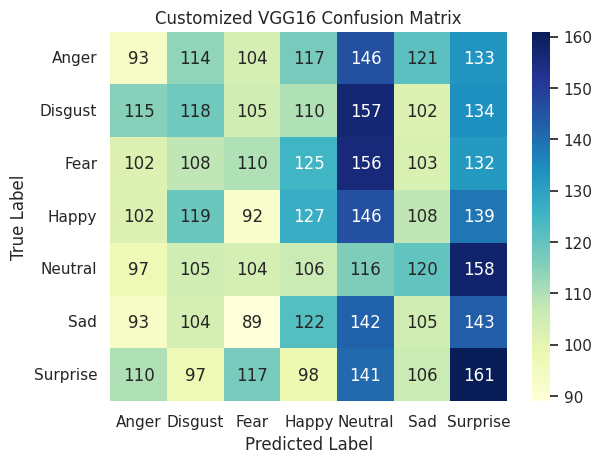

In [19]:
customized_vgg16_labels = test_generator.classes

customized_vgg16_Prediction = final_vgg16_model.predict(test_generator)

customized_vgg16_Prediction_labels = np.argmax(customized_vgg16_Prediction, axis = 1)

# Compute the confusion matrix
class_list = list(train_generator.class_indices)
cnf_mtx = confusion_matrix(customized_vgg16_labels, customized_vgg16_Prediction_labels)
sns.set()
sns.heatmap(
    cnf_mtx,
    annot = True,
    fmt = 'd',
    cmap = 'YlGnBu',
    xticklabels = class_list,
    yticklabels = class_list
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Customized VGG16 Confusion Matrix')
plt.show()

# Face Emotion Detection System

## Demonstration on images

### First Example

In [20]:
image_path = '/kaggle/input/testing-image/Testing-sameple/happyboy.jpg'
frame = cv2.imread(image_path)
frame.shape

(1440, 2160, 3)

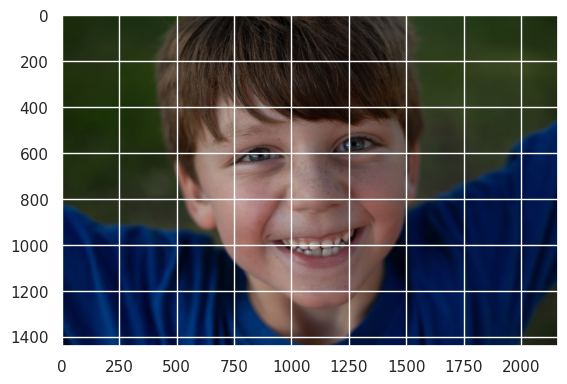

In [21]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [22]:
# Face detection algorithm that ignore the background, only crop the face (also convert it into gray image)
face_cascade = cv2.CascadeClassifier('/kaggle/input/squres/haarcascade_frontalface_default.xml')

In [23]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray.shape

(1440, 2160)

In [24]:
# Source : https://docs.opencv.org/3.1.0/d7/d8b/tutorial_py_face_detection.html#gsc.tab=0
# Source : https://stackoverflow.com/questions/36218385/parameters-of-detectmultiscale-in-opencv-using-python
# It is used to find all the possible faces in the video or image
faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5)
for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    face = gray[y:y + h, x:x + w]
    colour = frame[y:y + h, x:x + w]
    faces = face_cascade.detectMultiScale(face)
    # If no faces showed in the image or video, it will throw a error message
    if len(faces) == 0:
        print("Do not detect face")
    else:
        for (ex, ey, ew, eh) in faces:
            face_roi = colour[ey:ey + eh, ex:ex + ew]

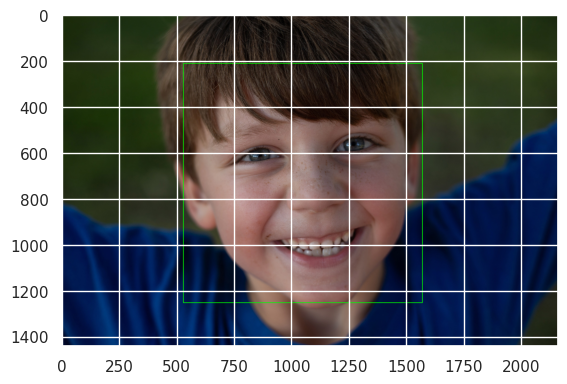

In [25]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

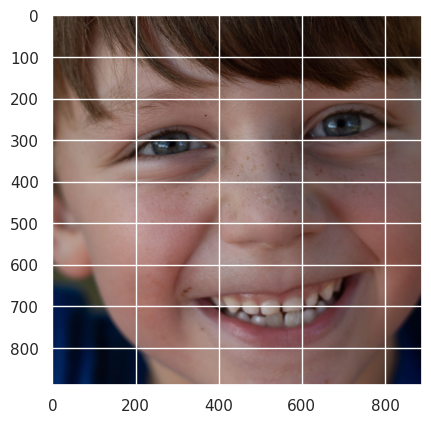

In [26]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [27]:
final_image = cv2.resize(face_roi, (64, 64))
final_image = np.expand_dims(final_image, axis = 0)
final_image = final_image/255.0

In [28]:
Predictions = final_vgg16_model.predict(final_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


In [29]:
Predictions[0]

array([8.8420585e-03, 2.5103593e-04, 1.4054370e-03, 9.5446664e-01,
       1.0098039e-02, 1.0218211e-02, 1.4718568e-02], dtype=float32)

In [30]:
array = np.array([8.8420827e-03, 2.5103660e-04, 1.4054395e-03, 9.5446646e-01,
                  1.0098061e-02, 1.0218234e-02, 1.4718594e-02])

# Find the index of the maximum value in the array
max_index = np.argmax(array)

# Retrieve the maximum value from the array
max_value = array[max_index]

print("The largest number is:", max_value)
print("Its index in the array is:", max_index)

The largest number is: 0.95446646
Its index in the array is: 3


As here we can see that "9.5446646e-01" is the largest number in the array.

In [31]:
np.argmax(Predictions)

3

In the fer2013 dataset: 0 = angry 1 = disgust 2 = fear 3 = happy 4 = neutral 5 = sad 6 = surprise

The code showing 3, which means the model predict that the image is equals to "happy". It is a correct predict as the image is "happy boy".

In [32]:
image2_path = '/kaggle/input/testing-image/Testing-sameple/surprised_man.jpeg'
frame2 = cv2.imread(image2_path)
frame2.shape

(892, 1300, 3)

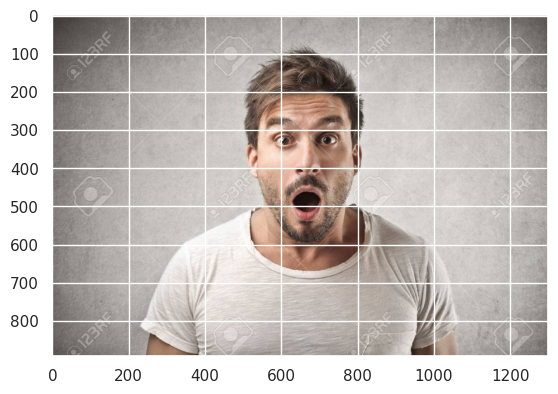

In [33]:
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))

In [34]:
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
gray2.shape

(892, 1300)

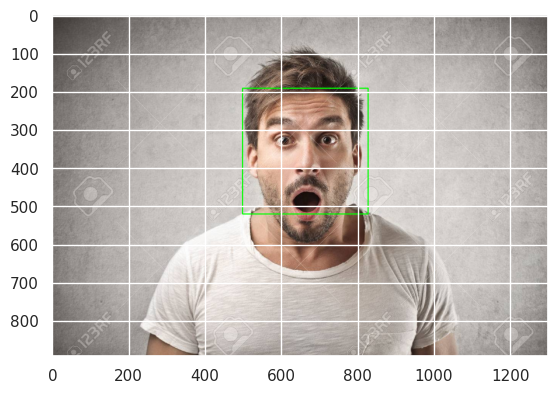

In [35]:
faces = face_cascade.detectMultiScale(gray2, scaleFactor = 1.1, minNeighbors = 5)
for (x, y, w, h) in faces:
    cv2.rectangle(frame2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    face = gray2[y:y + h, x:x + w]
    colour = frame2[y:y + h, x:x + w]
    faces = face_cascade.detectMultiScale(face)
    # If no faces showed in the image or video, it will throw a error message
    if len(faces) == 0:
        print("Do not detect face")
    else:
        for (ex, ey, ew, eh) in faces:
            face_roi = colour[ey:ey + eh, ex:ex + ew]

plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))

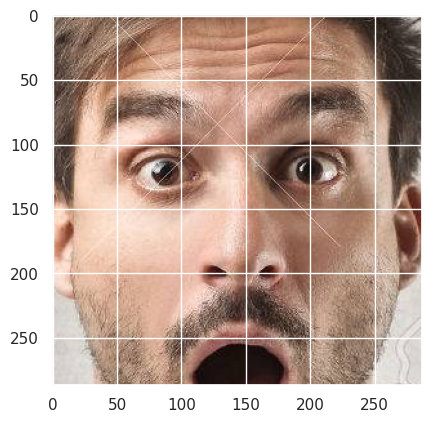

In [36]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [37]:
final_image2 = cv2.resize(face_roi, (64, 64))
final_image2 = np.expand_dims(final_image2, axis = 0)
final_image2 = final_image2/255.0

Predictions2 = final_vgg16_model.predict(final_image2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [38]:
Predictions2[0]

array([2.8438913e-04, 2.5721736e-06, 2.8893180e-02, 5.6542864e-04,
       6.1503993e-03, 1.5998972e-03, 9.6250421e-01], dtype=float32)

In [39]:
array = np.array([2.8438936e-04, 2.5721829e-06, 2.8893199e-02, 5.6542992e-04,
                  6.1503989e-03, 1.5998984e-03, 9.6250409e-01])

# Find the index of the maximum value in the array
max_index = np.argmax(array)

# Retrieve the maximum value from the array
max_value = array[max_index]

print("The largest number is:", max_value)
print("Its index in the array is:", max_index)

The largest number is: 0.96250409
Its index in the array is: 6


As here we can see that "9.6250409e-01" is the largest number in the array.

In [40]:
np.argmax(Predictions2)

6

The code showing 6, which means the model predict that the image is equals to "surprise". It is a correct predict as the image is "surprised man".

In [41]:
image3_path = '/kaggle/input/multiple-people/Screenshot 2024-04-06 at 1.07.09AM.png'
frame3 = cv2.imread(image3_path)
frame3.shape

(1912, 3418, 3)

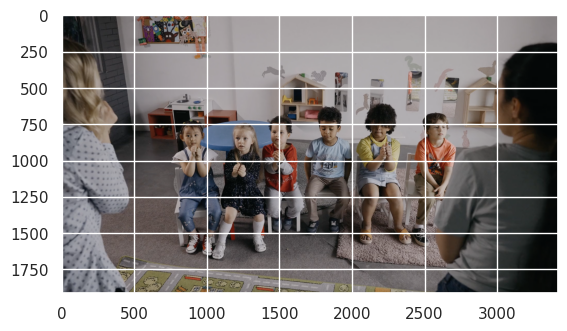

In [42]:
plt.imshow(cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB))

In [43]:
gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)
gray3.shape

(1912, 3418)

Do not detect face


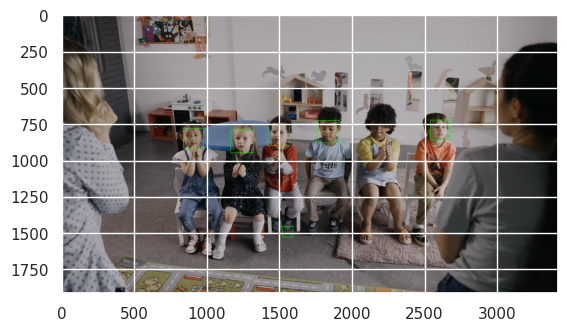

In [44]:
faces = face_cascade.detectMultiScale(gray3, scaleFactor = 1.29, minNeighbors = 6, minSize = (50,50))
for (x, y, w, h) in faces:
    cv2.rectangle(frame3, (x, y), (x + w, y + h), (0, 255, 0), 2)
    face = gray3[y:y + h, x:x + w]
    colour = frame3[y:y + h, x:x + w]
    faces = face_cascade.detectMultiScale(face)
    # If no faces showed in the image or video, it will throw a error message
    if len(faces) == 0:
        print("Do not detect face")
    else:
        for (ex, ey, ew, eh) in faces:
            face_roi = colour[ey:ey + eh, ex:ex + ew]

plt.imshow(cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


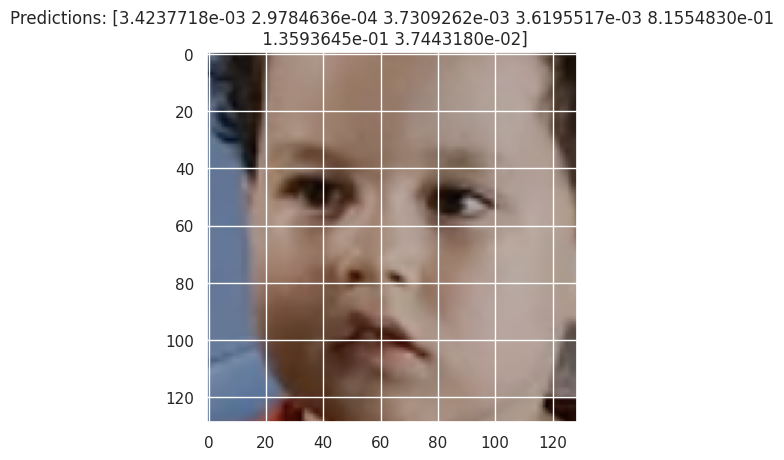

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


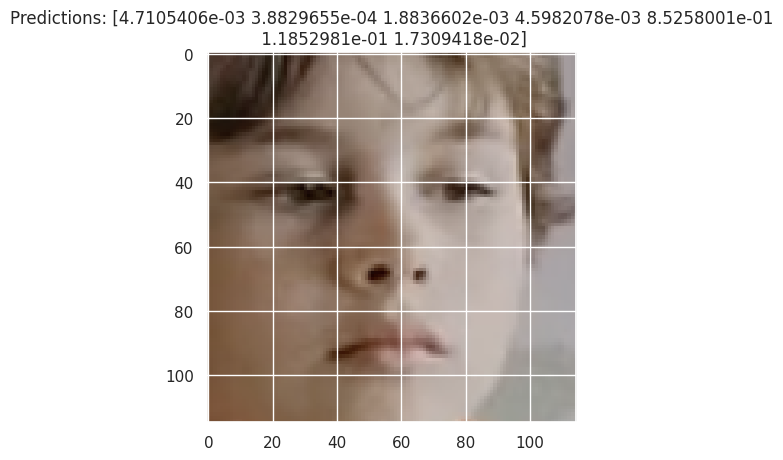

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


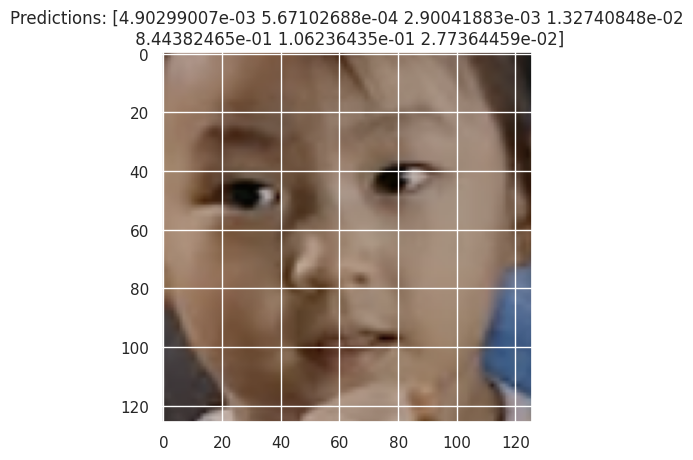

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


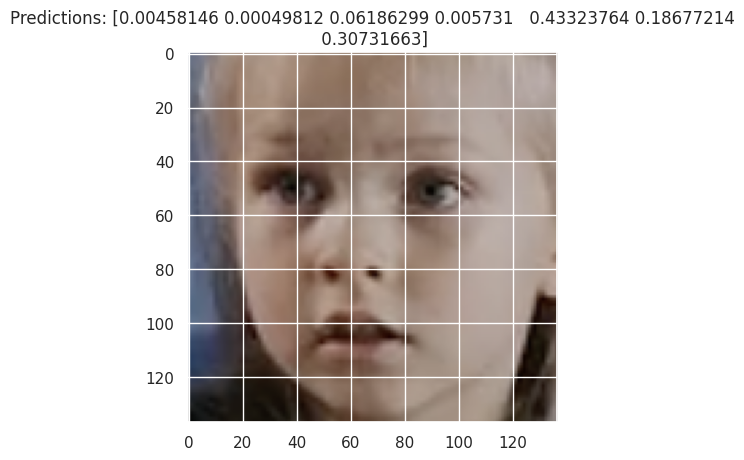

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


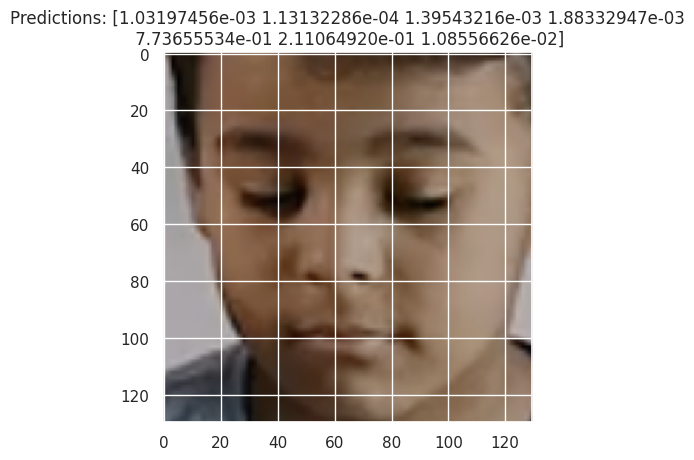

In [45]:
def predict_face(face_roi):
    final_image = cv2.resize(face_roi, (64, 64))
    final_image = np.expand_dims(final_image, axis=0)
    final_image = final_image / 255.0

    predictions = final_vgg16_model.predict(final_image)
    # Process the predictions and return the result
    # Replace this placeholder return statement with your actual processing logic
    return predictions

faces = face_cascade.detectMultiScale(gray3, scaleFactor=1.29, minNeighbors=6, minSize = (100,100))

for (x, y, w, h) in faces:
    cv2.rectangle(frame3, (x, y), (x + w, y + h), (0, 255, 0), 2)
    face = gray3[y:y + h, x:x + w]
    colour = frame3[y:y + h, x:x + w]
    small_faces = face_cascade.detectMultiScale(face)
    
    if len(small_faces) == 0:
        print("Do not detect face")
    else:
        for (ex, ey, ew, eh) in small_faces:
            face_roi = colour[ey:ey + eh, ex:ex + ew]
            predictions = predict_face(face_roi)  # Call your prediction function

            # Convert the array of predictions to a string representation
            prediction_str = ', '.join(str(p) for p in predictions)

            plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))
            plt.title("Predictions: " + prediction_str)
            plt.show()

Although it can detect 5 of the faces, but 1 of the human faces cannot be detected due to the feature of small face. So haar cascade has a problem that it cannot detect small faces. 

To solve the problem, lets try dlib frontal.

In [46]:
pip install dlib

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.4-cp310-cp310-linux_x86_64.whl size=3327188 sha256=7475d730261e97f375ce68e8b7876154076b0ffb1e0b256681887b8c3ae8d1e2
  Stored in directory: /root/.cache/pip/wheels/08/5e/55/a7db8d57920eb2c2aa41c36dc4c6d3cd12323865de191a7211
Successfully built dlib
Note: you may need to restart the kernel to use updated packages.


In [47]:
import dlib

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


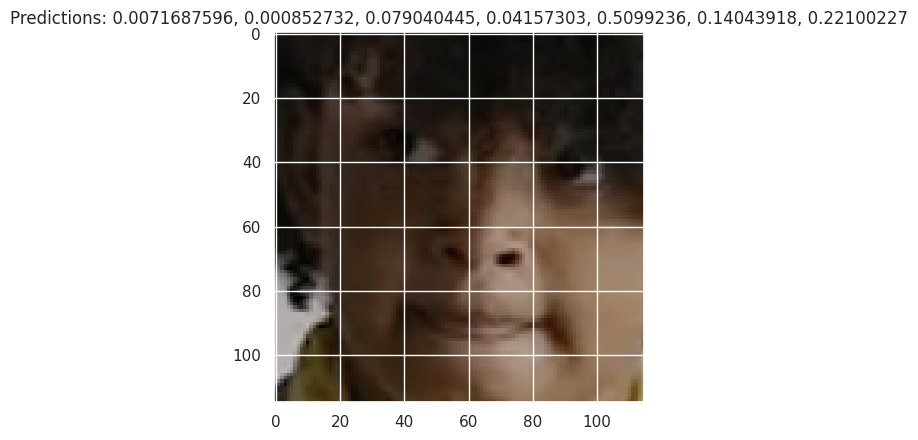

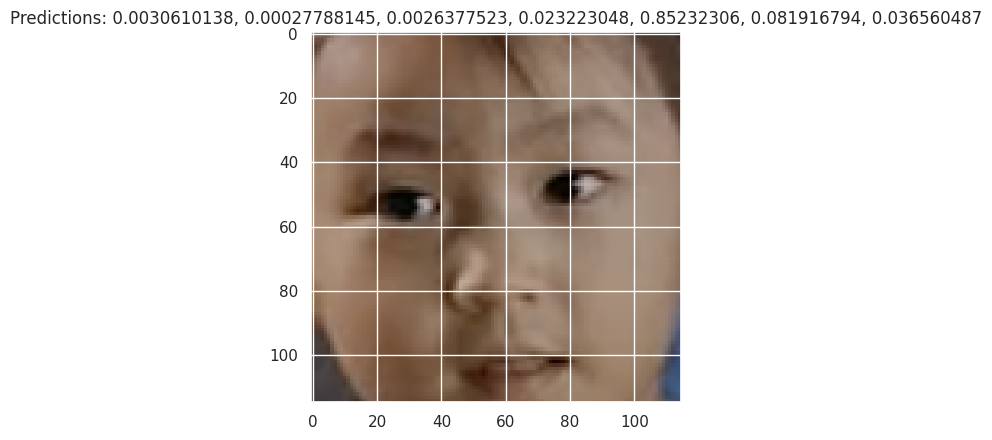

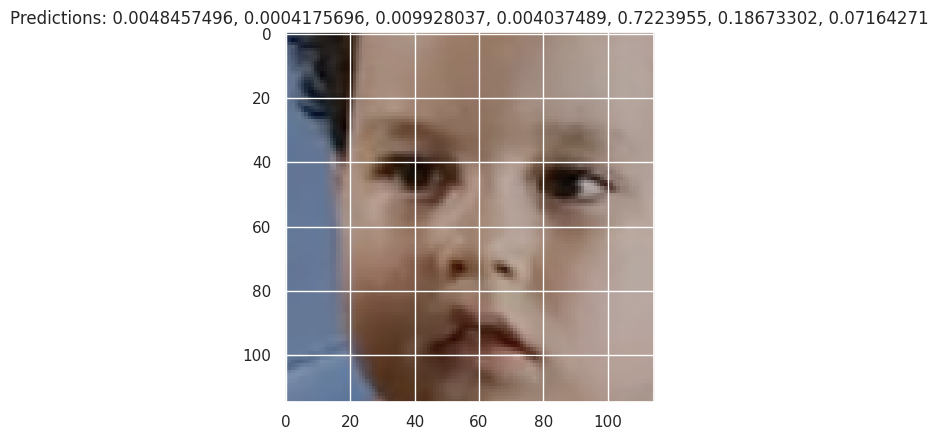

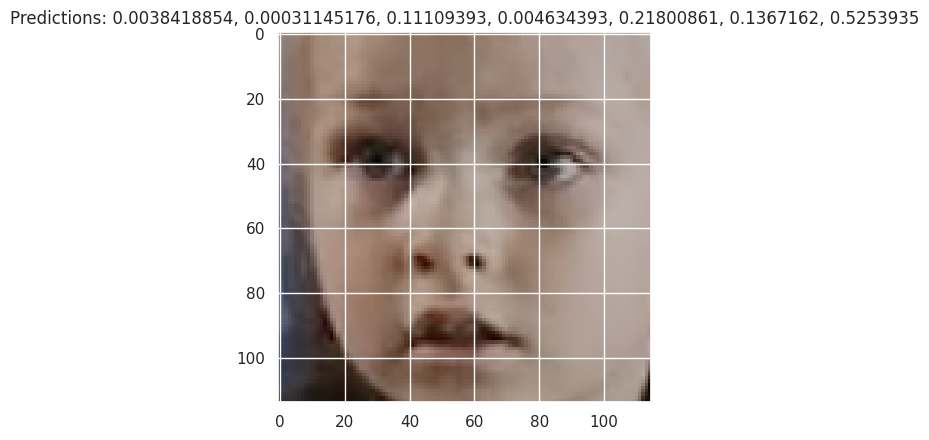

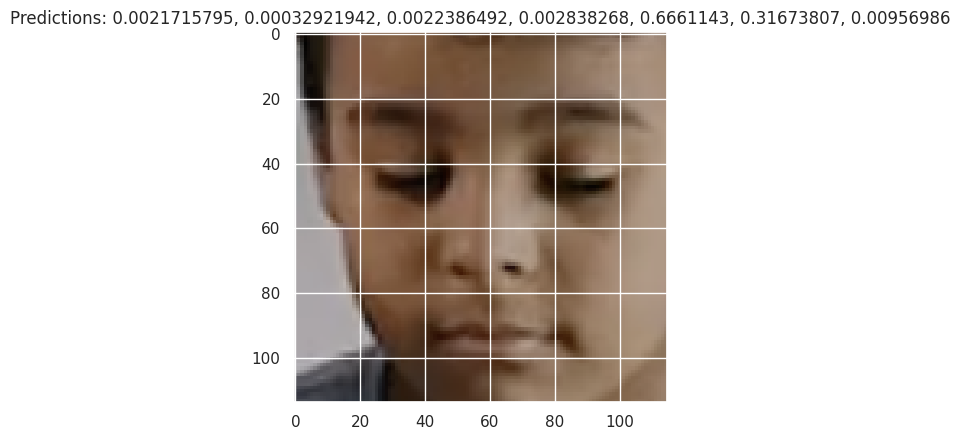

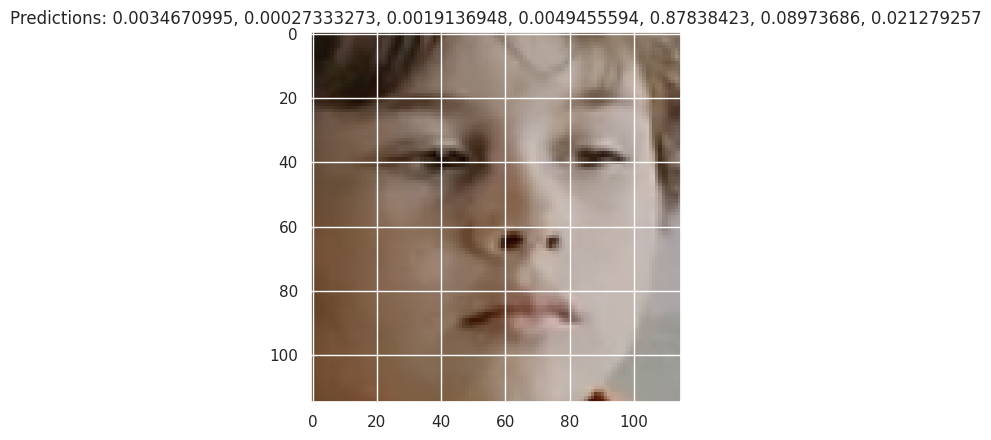

In [48]:
def predict_faces(face_rois):
    batch_size = len(face_rois)
    if batch_size == 0:
        return []

    final_images = [cv2.resize(face_roi, (64, 64)) for face_roi in face_rois]
    final_images = np.stack(final_images)
    final_images = final_images / 255.0

    predictions = final_vgg16_model.predict(final_images)
    # Process the predictions and return the results
    return predictions

# Initialize the face detector from Dlib
face_detector = dlib.get_frontal_face_detector()
face_detector = dlib.cnn_face_detection_model_v1("/kaggle/input/fcae-detect/mmod_human_face_detector.dat")

# Load the image
frame3 = cv2.imread("/kaggle/input/multiple-people/Screenshot 2024-04-06 at 1.07.09AM.png")

# Convert the image to grayscale
gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_detector(gray3)

face_regions = []

scaling_factor = 1.3  # Adjust the scaling factor to increase or decrease the size of the cropped region

for face in faces:
    x, y, w, h = face.rect.left(), face.rect.top(), face.rect.width(), face.rect.height()
    
    # Increase the size of the face region using the scaling factor
    scaled_w = int(w * scaling_factor)
    scaled_h = int(h * scaling_factor)
    scaled_x = max(0, x - int((scaled_w - w) / 2))
    scaled_y = max(0, y - int((scaled_h - h) / 2))
    
    face_gray = gray3[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
    face_color = frame3[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
    small_faces = face_detector(face_gray, upsample_num_times=0)

    if len(small_faces) > 0:
        for small_face in small_faces:
            ex, ey, ew, eh = small_face.rect.left(), small_face.rect.top(), small_face.rect.width(), small_face.rect.height()
            face_roi = face_color[ey:ey + eh, ex:ex + ew]
            if face_roi.size != 0:
                face_regions.append(face_roi)

# Predict the faces in batches
batch_size = 10
num_faces = len(face_regions)
for i in range(0, num_faces, batch_size):
    batch_faces = face_regions[i:i + batch_size]
    predictions = predict_faces(batch_faces)

    for j, prediction in enumerate(predictions):
        prediction_str = ', '.join(str(p) for p in prediction)

        # Display the face ROI and frame with prediction
        plt.figure()
        plt.imshow(batch_faces[j][:, :, ::-1])
        plt.title("Predictions: " + prediction_str)
        plt.show()

        # Draw prediction text on the original frame
        cv2.putText(frame3, "Predictions: " + prediction_str, (x + 5, y - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

## Demonstration on Video

### Frontal Face Experiment

In [50]:
# def predict_faces(face_rois):
#     batch_size = len(face_rois)
#     if batch_size == 0:
#         return []

#     final_images = [cv2.resize(face_roi, (64, 64)) for face_roi in face_rois]
#     final_images = np.stack(final_images)
#     final_images = final_images / 255.0

#     predictions = final_vgg16_model.predict(final_images)
#     # Process the predictions and return the results
#     return predictions

# def emotion_recog(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     faces = face_detector(gray)
    
#     # Predict the emotions for each face
#     for face in faces:
#         x, y, w, h = face.rect.left(), face.rect.top(), face.rect.right(), face.rect.bottom()
#         face_gray = gray[y:y + h, x:x + w]
#         face_color = frame[y:y + h, x:x + w]
        
#         # Resize the face region for prediction
#         face_resize = cv2.resize(face_gray, (48, 48))
#         face_resize = np.expand_dims(face_resize, axis=0) / 255.0
        
#         # Predict emotions
#         predictions = predict_faces.predict(face_resize)[0]
#         emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#         pred_label = emotion_labels[np.argmax(predictions)]
#         pred_confidence = np.max(predictions)

#         # Draw rectangle on the frame
#         cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
#         # Display emotion label with highest confidence
#         cv2.putText(frame, f"Emotion: {pred_label}", (x, y - 10),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)
#         cv2.putText(frame, f"Confidence: {pred_confidence:.2f}", (x, y - 35),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)
    
#     return frame

In [51]:
# # Initialize the face detector from Dlib
# face_detector = dlib.get_frontal_face_detector()
# face_detector = dlib.cnn_face_detection_model_v1("/kaggle/input/fcae-detect/mmod_human_face_detector.dat")

# # Load the video
# cap = cv2.VideoCapture('/kaggle/input/mp4-upload/8159867-hd_1920_1080_25fps.mp4')

# ret, frame = cap.read()
# frame_height, frame_width, _ = frame.shape

# out = cv2.VideoWriter('newtry_multiple_done.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (frame_width, frame_height))
# print("Processing Video......")

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         out.release()
#         break
    
#     output = emotion_recog(frame)
#     out.write(output)

# out.release()
# print("Done processing video")

In [52]:
# def emotion_recog(frame):
#     emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprise"}

#     # Initialize the face detector from Dlib
#     face_detector = dlib.get_frontal_face_detector()

#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     faces = face_detector(gray_frame)

#     for face in faces:
#         # Extract the bounding box coordinates of the face
#         x, y, w, h = face.left(), face.top(), face.width(), face.height()

#         cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
#         face_roi = gray_frame[y:y + h, x:x + w]
#         face_rgb = cv2.cvtColor(face_roi, cv2.COLOR_GRAY2RGB)
#         cropped_img = cv2.resize(face_rgb, (64, 64))
#         cropped_img = cropped_img.reshape((1, 64, 64, 3))

#         emotion_prediction = final_vgg16_model.predict(cropped_img)
#         maxindex = int(np.argmax(emotion_prediction))
#         cv2.putText(frame, emotion_dict[maxindex], (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

#     return frame

In [53]:
# # Source : https://www.youtube.com/watch?v=Lmmo71aZTLg

# cap = cv2.VideoCapture('/kaggle/input/testing-image/Testing-sameple/emotion_sample_video.mp4')

# ret, frame = cap.read()

# frame_height, frame_width, _ = frame.shape

# out = cv2.VideoWriter('newtry_normal_done.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (frame_width, frame_height))
# print("Processing Video......")

# while cap.isOpened():
#   ret, frame = cap.read()
#   if not ret:
#     out.release()
#     break
#   output = emotion_recog(frame)
#   out.write(output)

# out.release()
# print("Done processing video")

In the video demostration experiment, we can see that the green rectangle that using dlib frontal is more stable than the haar cascade. Therefore, dlib is better than haar cascade.

Now, the problem is it only can detect the large faces. To able the model can detect the smaller faces, I will use another algorithm to combine with my own customized VGG16 model to perform better.

### Frontal Faces + Small Faces

In [60]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_faces(face_rois):
    batch_size = len(face_rois)
    if batch_size == 0:
        return []

    final_images = [cv2.resize(face_roi, (64, 64)) for face_roi in face_rois]
    final_images = np.stack(final_images)
    final_images = final_images / 255.0

    predictions = final_vgg16_model.predict(final_images)
    # Process the predictions and return the results
    return predictions

# Initialize the face detector from Dlib
face_detector = dlib.get_frontal_face_detector()
face_detector = dlib.cnn_face_detection_model_v1("/kaggle/input/fcae-detect/mmod_human_face_detector.dat")

# Load the video
video_path = '/kaggle/input/sad-cry/5981354-hd_1366_720_25fps.mp4'
cap = cv2.VideoCapture(video_path)

# Get the video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object
output_path = 'newtry_normal_done.avi'
fourcc = cv2.VideoWriter_fourcc(*"MJPG")  # Adjust the codec as needed
 
output_video = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Dictionary to store emotion counts
emotion_counts = {
    "Angry": 0,
    "Disgust": 0,
    "Fear": 0,
    "Happy": 0,
    "Neutral": 0,
    "Sad": 0,
    "Surprise": 0
}

# Dictionary to map numeric labels to emotion words
emotion_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        output_video.release()
        break
    
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_detector(gray)
    
    for face in faces:
        x, y, w, h = face.rect.left(), face.rect.top(), face.rect.width(), face.rect.height()
        
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Extract the face region
        face_region = frame[y:y+h, x:x+w]
        
        # Predict the face
        predictions = predict_faces([face_region])[0]
        
        # Find the index of the emotion with the highest predicted score
        max_index = np.argmax(predictions)
        
        # Get the emotion label with the highest predicted score
        emotion_label = emotion_dict[max_index]
        
        # Increment the count for the detected emotion
        emotion_counts[emotion_label] += 1
        
        # Display the emotion label
        cv2.putText(frame, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display the emotion counts in the top right corner
    counts_text = ", ".join([f"{emotion}: {count}" for emotion, count in emotion_counts.items()])
    text_width, text_height = cv2.getTextSize(counts_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
    text_x = frame_width - text_width - 10
    text_y = 30
    
    cv2.putText(frame, counts_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Write the annotated frame to the output video
    output_video.write(frame)

cap.release()
output_video.release()

print("Done processing video")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


KeyboardInterrupt: 

In [50]:
def predict_faces(face_rois):
    batch_size = len(face_rois)
    if batch_size == 0:
        return []

    final_images = [cv2.resize(face_roi, (64, 64)) for face_roi in face_rois]
    final_images = np.stack(final_images)
    final_images = final_images / 255.0

    predictions = final_vgg16_model.predict(final_images)
    # Process the predictions and return the results
    return predictions

# Initialize the face detector from Dlib
face_detector = dlib.get_frontal_face_detector()
face_detector = dlib.cnn_face_detection_model_v1("/kaggle/input/fcae-detect/mmod_human_face_detector.dat")

# Load the video
video_path = '/kaggle/input/distance-try/My Movie 5.mp4'
cap = cv2.VideoCapture(video_path)

# Get the video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object
output_path = 'newtry_normal_done.avi'
fourcc = cv2.VideoWriter_fourcc(*"MJPG")  # Adjust the codec as needed
 
output_video = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Dictionary to store emotion counts
emotion_counts = {
    "Angry": 0,
    "Disgust": 0,
    "Fear": 0,
    "Happy": 0,
    "Neutral": 0,
    "Sad": 0,
    "Surprise": 0
}

# Dictionary to map numeric labels to emotion words
emotion_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

# Set the threshold for alerting the teacher
alert_threshold = 1

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        output_video.release()
        break
    
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_detector(gray)
    
    # Reset emotion counts for each frame
    emotion_counts = {
        "Angry": 0,
        "Disgust": 0,
        "Fear": 0,
        "Happy": 0,
        "Neutral": 0,
        "Sad": 0,
        "Surprise": 0
    }
    
    for face in faces:
        x, y, w, h = face.rect.left(), face.rect.top(), face.rect.width(), face.rect.height()
        
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Extract the face region
        face_region = frame[y:y+h, x:x+w]
        
        # Predict the face
        predictions = predict_faces([face_region])[0]
        
        # Find the index of the emotion with the highest predicted score
        max_index = np.argmax(predictions)
        
        # Get the emotion label with the highest predicted score
        emotion_label = emotion_dict[max_index]
        
        # Increment the count for the detected emotion
        emotion_counts[emotion_label] += 1
        
        # Display the emotion label
        cv2.putText(frame, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
            # Check for high counts and display an alert if necessary
        if emotion_counts["Sad"] > alert_threshold or emotion_counts["Disgust"] > alert_threshold or emotion_counts["Fear"] > alert_threshold or emotion_counts["Angry"] > alert_threshold:
            alert_text = "Alert: Teaching adjustment required!"
            cv2.putText(frame, alert_text, (x, y - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Display the emotion counts in the top right corner
    counts_text = ", ".join([f"{emotion}: {count}" for emotion, count in emotion_counts.items()])
    text_width, text_height = cv2.getTextSize(counts_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
    text_x = frame_width - text_width - 10
    text_y = 30
    
    cv2.putText(frame, counts_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Write the annotated frame to the output video
    output_video.write(frame)

cap.release()
output_video.release()

print("Done processing video")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━